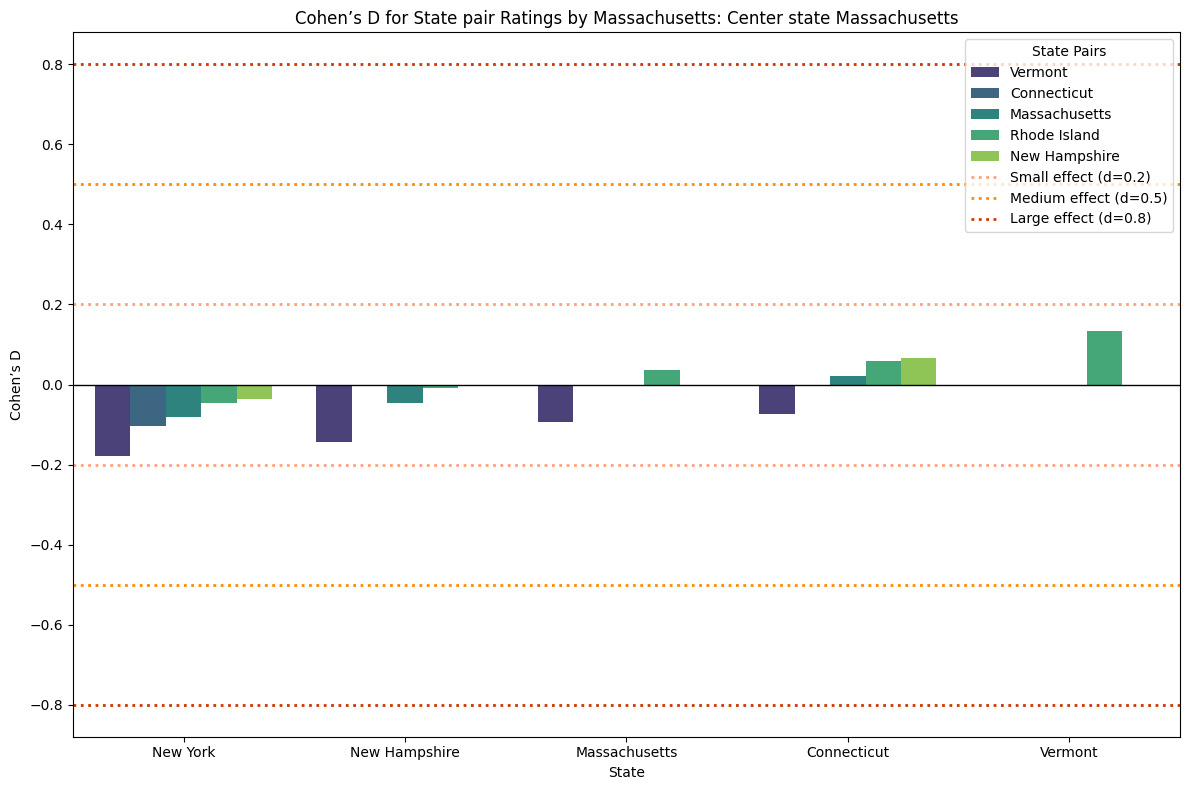

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

US_ratings = pd.read_csv('USData/BA_US_states_all.csv')


#csv file containing all the states and their neighbouring states
#empty list for states that have no neighbours (e.g Alazka, Hawaii)
neighbours_df = pd.read_csv('additionalData/bordering_states.csv', dtype={'state':'string', 
                                                                          'neighbours': 'string'})
neighbours_df["neighbours"] = neighbours_df["neighbours"].fillna("").apply(lambda x: x.split(";") if x else [])


def gather_region_ratings(state, US_ratings, neighbours_df):
    neighbours = neighbours_df.loc[neighbours_df['state'] == state, 'neighbours'].values[0]
    
    region_states = [state] + neighbours    
    region_ratings = US_ratings[US_ratings['beer_state'].isin(region_states)]

    in_region_ratings = region_ratings[region_ratings['user_state'].isin(region_states)]
    not_in_region_ratings = region_ratings[~region_ratings['user_state'].isin(region_states)]
    
    return in_region_ratings, not_in_region_ratings

states = US_ratings['beer_state'].unique()

all_ratings = {'region': [], 'rating': [], 'rating_type': [], 'user_state': []}

for state in states:
    in_region, non_region = gather_region_ratings(state, US_ratings, neighbours_df)

    region_name = f"{state}"
    
    # Add In-Region ratings to the dictionary
    all_ratings['region'].extend([region_name] * len(in_region))
    all_ratings['rating'].extend(in_region['rating'].tolist())
    all_ratings['rating_type'].extend(['In-Region'] * len(in_region))
    all_ratings['user_state'].extend(in_region['user_state'].tolist())
    
    # Add Non-Region ratings to the dictionary
    all_ratings['region'].extend([region_name] * len(non_region))
    all_ratings['rating'].extend(non_region['rating'].tolist())
    all_ratings['rating_type'].extend(['Non-Region'] * len(non_region))
    all_ratings['user_state'].extend(non_region['user_state'].tolist())

ratings_df = pd.DataFrame(all_ratings)

ratings_df = ratings_df[ratings_df['rating_type'] == 'In-Region']
ratings_df = ratings_df.drop('rating_type', axis=1)
ratings_df['rating_type'] = np.where(ratings_df['region'] == ratings_df['user_state'], 'In-State', 'Non-State')

def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1) 
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std


# Creating a plot of the Cohen's D values between every user_state of a region without calculating it twice.

subset = ratings_df[ratings_df['region'] == 'Massachusetts']
cohen_results = []
processed_pairs = set()
    
for state1 in subset['user_state'].unique():
    for state2 in subset['user_state'].unique():
        if state1 != state2:
            state_pair = tuple(sorted([state1, state2]))
                
            if state_pair in processed_pairs:
                continue
                
            ratings_state1 = subset[subset['user_state'] == state1]['rating']
            ratings_state2 = subset[subset['user_state'] == state2]['rating']
                
            if len(ratings_state1) == 0 or len(ratings_state2) == 0:
                continue
                
            d_value = cohen_d(ratings_state1, ratings_state2)
            cohen_results.append((state1, state2, d_value))
            processed_pairs.add(state_pair)
    
cohen_df_Massachusetts = pd.DataFrame(cohen_results, columns=['State1', 'State2', 'Cohen_d'])
    
cohen_df_Massachusetts = cohen_df_Massachusetts.sort_values(by='Cohen_d')
    
plt.figure(figsize=(12, 8))
sns.barplot(
    x='State1', 
    y='Cohen_d', 
    data=cohen_df_Massachusetts, 
    palette='viridis', 
    hue='State2'
)

plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(y=-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(y=0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(y=-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(y=0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(y=-0.8, color='#CD3700', linestyle=':', linewidth=2)
    
plt.xlabel('State')
plt.ylabel('Cohen’s D')
plt.title('Cohen’s D for State pair Ratings by Massachusetts: Center state Massachusetts')
plt.xticks(rotation=0)
plt.legend(title='State Pairs', loc='upper right')
plt.tight_layout()
    


plt.savefig("modules/9.png")